# Fáza 3 - Strojové učenie
Práca bola rozdelená férovo pre oboch zúčastnených
Adam Kubaliak 50%
Norbert Matuška 50% 

In [123]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.model_selection import learning_curve


In [98]:
data_train_best_features = pd.read_csv("data_train_best_features.csv")
data_test_best_features = pd.read_csv("data_test_best_features.csv")
best_features_columns = data_train_best_features.columns.tolist()

## 3.1 Jednoduchý klasifikátor na základe závislostí v dátach

### 3.1 A
(A-3b) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň). 

In [100]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature          # Index of the feature to split on
        self.threshold = threshold      # Threshold value for the split
        self.left = left                # Left subtree
        self.right = right              # Right subtree
        self.value = value              # Predicted class if leaf node

class DecisionTreeClassifierID3:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth                      # Maximum depth of the tree
        self.min_samples_split = min_samples_split      # Minimum number of samples to split
        self.root = None                                # Root node of the tree

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.features_ = X.columns
        data = X.copy()
        data['mwra'] = y
        self.root = self.build_tree(data, depth=0)

    def build_tree(self, data, depth):
        X = data.drop('mwra', axis=1)
        y = data['mwra']
        num_samples, num_features = X.shape

        # Stopping criteria
        if (len(set(y)) == 1 or
            num_samples < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth)):
            leaf_value = self.most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self.best_split(data)
        if best_feature is None:
            leaf_value = self.most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Split the data
        left_idxs = X[X[best_feature] <= best_threshold].index
        right_idxs = X[X[best_feature] > best_threshold].index

        left = self.build_tree(data.loc[left_idxs], depth + 1)
        right = self.build_tree(data.loc[right_idxs], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def best_split(self, data):
        X = data.drop('mwra', axis=1)
        y = data['mwra']
        best_gain = -1
        split_feature, split_threshold = None, None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                gain = self.information_gain(y, X[feature], threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature
                    split_threshold = threshold

        return split_feature, split_threshold

    def information_gain(self, y, feature_col, threshold):
        parent_entropy = self.entropy(y)

        # Generate splits
        left_idxs = feature_col <= threshold
        right_idxs = feature_col > threshold
        if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
            return 0

        # Weighted average child entropy
        n = len(y)
        n_left, n_right = len(y[left_idxs]), len(y[right_idxs])
        e_left, e_right = self.entropy(y[left_idxs]), self.entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Information gain
        ig = parent_entropy - child_entropy
        return ig

    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        ps = ps[ps > 0]
        entropy = -np.sum(ps * np.log2(ps))
        return entropy

    def most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return X.apply(self.traverse_tree, axis=1, args=(self.root,))

    def traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        feature_val = x[node.feature]
        if feature_val <= node.threshold:
            return self.traverse_tree(x, node.left)
        else:
            return self.traverse_tree(x, node.right)

In [101]:
trainX = data_train_best_features.drop('mwra', axis=1)
trainY = data_train_best_features['mwra']

# Convert target variable to categorical if it's not
trainY = trainY.astype(int)

clf = DecisionTreeClassifierID3(max_depth=5)
clf.fit(trainX, trainY)


### 3.1 B
(B-1b) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.

In [102]:
testX = data_test_best_features.drop("mwra", axis=1)
testY = data_test_best_features["mwra"]

predictions = clf.predict(testX)

# Evaluate the classifier
accuracy = accuracy_score(testY, predictions)
precision = precision_score(testY, predictions)
recall = recall_score(testY, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(testY, predictions))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(testY, predictions))

Accuracy: 89.96%
Precision: 89.82%
Recall: 95.24%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85       983
         1.0       0.90      0.95      0.92      1787

    accuracy                           0.90      2770
   macro avg       0.90      0.88      0.89      2770
weighted avg       0.90      0.90      0.90      2770

Confusion Matrix:
[[ 790  193]
 [  85 1702]]


### 3.1 C
(C-1b) Zístite či Váš ID3 klasifikátor má overfit.


In [103]:
train_predictions = clf.predict(trainX)
train_accuracy = accuracy_score(trainY, train_predictions)
train_precision = precision_score(trainY, train_predictions)
train_recall = recall_score(trainY, train_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Precision: {train_precision * 100:.2f}%")
print(f"Training Recall: {train_recall * 100:.2f}%")

print("\nComparison of Training and Test Performance:")
print(f"Accuracy Difference: {train_accuracy - accuracy:.4f}")
print(f"Precision Difference: {train_precision - precision:.4f}")
print(f"Recall Difference: {train_recall - recall:.4f}")


Training Accuracy: 90.97%
Training Precision: 90.61%
Training Recall: 96.03%

Comparison of Training and Test Performance:
Accuracy Difference: 0.0101
Precision Difference: 0.0079
Recall Difference: 0.0079


Výsledky:
Accuracy rozdiel: 1.01%
Precision rozdiel: 0.79%
Recall rozdiel: 0.79%

- Náš klasifikátor rozhodovacieho stromu funguje podobne na tréningových aj testovacích súboroch údajov tým pádom malé rozdiely vo výkone naznačujú, že overfit nie je pre náš model problem.
- Model taktiez dobre generalizuje nové údaje, čo naznačuje, že zachytil základné vzorce potrebné na vytváranie presných predpovedí bez toho, aby bol ovplyvnený šumom v trénovacích údajoch.

## 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia

### 3.2 A
(A-1b) Na trénovanie využite jeden stromový algoritmus v scikit-learn.

In [104]:
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(trainX, trainY)

predictions_scikit_tree = tree_model.predict(testX)

accuracy_scikit_tree = accuracy_score(testY, predictions_scikit_tree)
precision_scikit_tree = precision_score(testY, predictions_scikit_tree)
recall_scikit_tree = recall_score(testY, predictions_scikit_tree)

print(f"Accuracy: {accuracy_scikit_tree * 100:.2f}")
print(f"Precision: {precision_scikit_tree * 100:.2f}")
print(f"Recall: {recall_scikit_tree * 100:.2f}")

Accuracy: 89.31
Precision: 89.13
Recall: 95.02


## 3.2 B
(B-1b) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.


In [105]:
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel for simplicity
svm_model.fit(trainX, trainY)

predictions_scikit_svm = svm_model.predict(testX)

accuracy_scikit_svm = accuracy_score(testY, predictions_scikit_svm)
precision_scikit_svm = precision_score(testY, predictions_scikit_svm)
recall_scikit_svm = recall_score(testY, predictions_scikit_svm)

print(f"Accuracy: {accuracy_scikit_svm * 100:.2f}")
print(f"Precision: {precision_scikit_svm * 100:.2f}")
print(f"Recall: {recall_scikit_svm * 100:.2f}")

Accuracy: 91.08
Precision: 90.44
Recall: 96.36


In [106]:
# --------- Confusion Matrix Comparison ---------
# Confusion Matrix for Decision Tree
conf_matrix_tree = confusion_matrix(testY, predictions_scikit_tree)
print("\nDecision Tree - Confusion Matrix:")
print(conf_matrix_tree)

# Confusion Matrix for SVM
conf_matrix_svm = confusion_matrix(testY, predictions_scikit_svm)
print("\nSVM - Confusion Matrix:")
print(conf_matrix_svm)

# --------- Classification Report Comparison ---------
# Detailed Report for Decision Tree
print("\nDecision Tree - Classification Report:")
print(classification_report(testY, predictions_scikit_tree))

# Detailed Report for SVM
print("\nSVM - Classification Report:")
print(classification_report(testY, predictions_scikit_svm))


Decision Tree - Confusion Matrix:
[[ 776  207]
 [  89 1698]]

SVM - Confusion Matrix:
[[ 801  182]
 [  65 1722]]

Decision Tree - Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84       983
         1.0       0.89      0.95      0.92      1787

    accuracy                           0.89      2770
   macro avg       0.89      0.87      0.88      2770
weighted avg       0.89      0.89      0.89      2770


SVM - Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.87       983
         1.0       0.90      0.96      0.93      1787

    accuracy                           0.91      2770
   macro avg       0.91      0.89      0.90      2770
weighted avg       0.91      0.91      0.91      2770


## 3.2 C
(C-1b) Porovnajte výsledky s ID3 z prvého kroku.


In [107]:
scikit_tree_metrics = {
    "Accuracy": accuracy_scikit_tree,
    "Precision": precision_scikit_tree,
    "Recall": recall_scikit_tree
}

scikit_svm_metrics = {
    "Accuracy": accuracy_scikit_svm,
    "Precision": precision_scikit_svm,
    "Recall": recall_scikit_svm
}

id3_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall
}

comparison_df = pd.DataFrame(
    {
        "ID3 Classifier": id3_metrics,
        "Decision Tree": scikit_tree_metrics,
        "SVM": scikit_svm_metrics
    }
)

comparison_df

,ID3 Classifier,Decision Tree,SVM
Accuracy,0.899639,0.893141,0.910830
Precision,0.898153,0.891339,0.904412
Recall,0.952434,0.950196,0.963626


SVM je model s najlepsím výkonom vo všetkých metrikách: accuracy, precision a recall. Preto je pre tento dataset SVM najlepšiou  voľbou. ID3 Classifier sa dosť približuje, najmä v Recall, ktorý prevyšuje výkon decision tree a približuje sa k SVM. V porovnaní s ID3 a SVM, decision tree vo všetkých metrikách trochu zaostáva. Napriek tomu jeho výkon nie je zlý; rozdiely sú dostatočne malé.

## 3.2 D
(D-1b) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus


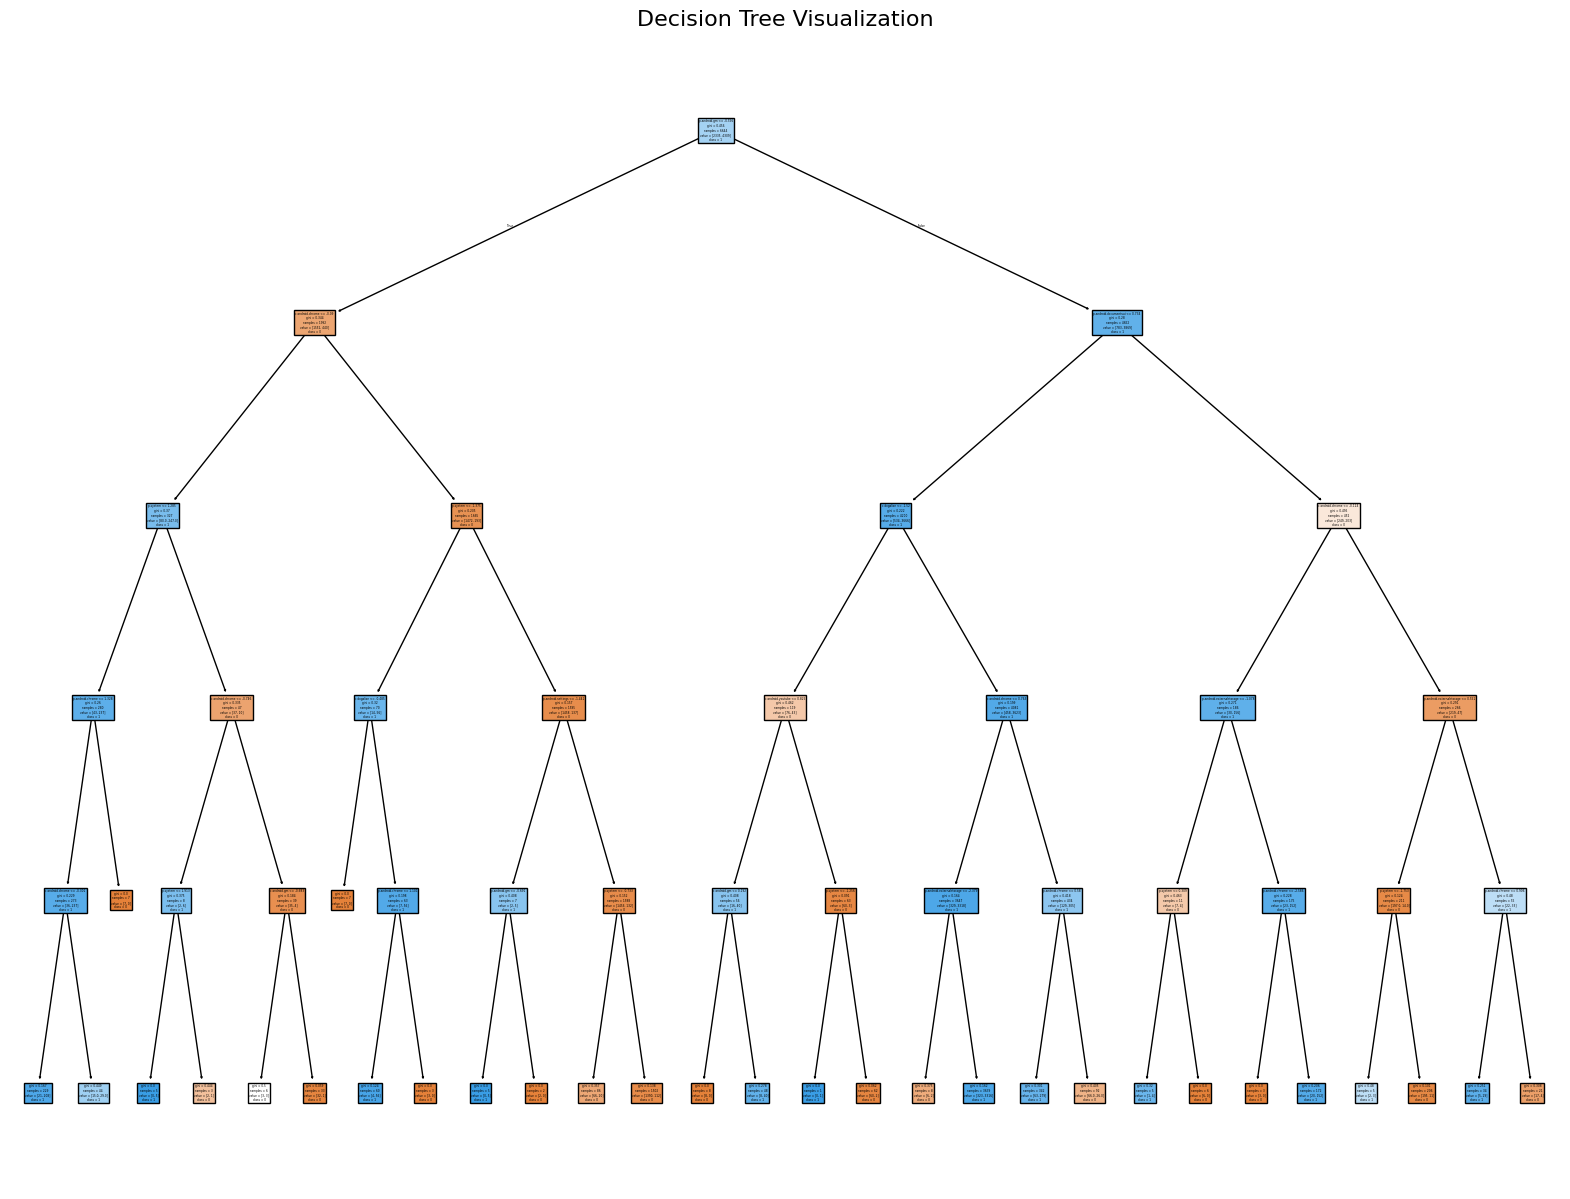

In [108]:
plt.figure(figsize=(20, 15))
plot_tree(tree_model, feature_names=best_features_columns, class_names=[str(cls) for cls in set(trainY)], filled=True)
plt.title("Decision Tree Visualization", fontsize=16)
plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()

## 3.2 E
(E-1b) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall


In [109]:
comparison_df

,ID3 Classifier,Decision Tree,SVM
Accuracy,0.899639,0.893141,0.910830
Precision,0.898153,0.891339,0.904412
Recall,0.952434,0.950196,0.963626


## 3.3 Optimalizácia alias hyperparameter tuning

### 3.3 A
Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).


In [110]:
parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=SVC(random_state=42), 
                           param_grid=parameters, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=1)
grid_search.fit(trainX, trainY)
best_svm = grid_search.best_estimator_

print(f'Best parameters : {grid_search.best_params_}')

predictions_best_svm = best_svm.predict(testX)

accuracy_best = accuracy_score(testY, predictions_best_svm)
precision_best = precision_score(testY, predictions_best_svm)
recall_best = recall_score(testY, predictions_best_svm)

print(f'Accuracy: {accuracy_best * 100:.2f}')
print(f'Precision: {precision_best * 100:.2f}')
print(f'Recall: {recall_best * 100:.2f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 92.31
Precision: 92.22
Recall: 96.19


Pre zvolený algoritmus, čo je SVM, sme použili GridSearchCV na optimalizáciu hyperparametrov. Najlepšia hodnota parametrov bola kombinácia c = 1, gamma = scale a kernel = rbf.
Pri tejto kombinácii sme dosiahli presnosť 92.31%

### 3.3 B
Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).

In [111]:
bagged_svm = BaggingClassifier(estimator=SVC(C=1, kernel='rbf', gamma='scale', random_state=42),
                                 n_estimators=10,
                                 random_state=42)
bagged_svm.fit(trainX, trainY)

predictions_bagged = bagged_svm.predict(testX)

accuracy_bagged = accuracy_score(testY, predictions_bagged)
precision_bagged = precision_score(testY, predictions_bagged)
recall_bagged = recall_score(testY, predictions_bagged)

print(f'Bagged SVM')
print(f'Accuracy: {accuracy_bagged * 100:.2f}%')
print(f'Precision: {precision_bagged * 100:.2f}%')
print(f'Recall: {recall_bagged * 100:.2f}%')

Bagged SVM
Accuracy: 92.31%
Precision: 92.22%
Recall: 96.19%


In [112]:
boosting_model = GradientBoostingClassifier(n_estimators=10, random_state=42)
boosting_model.fit(trainX, trainY)

predictions_boosting = boosting_model.predict(testX)

accuracy_boosting = accuracy_score(testY, predictions_boosting)
precision_boosting = precision_score(testY, predictions_boosting)
recall_boosting = recall_score(testY, predictions_boosting)

print(f'Gradient Boosting')
print(f'Accuracy: {accuracy_boosting * 100:.2f}%')
print(f'Precision: {precision_boosting * 100:.2f}%')
print(f'Recall: {recall_boosting * 100:.2f}%')


Gradient Boosting
Accuracy: 89.35%
Precision: 88.53%
Recall: 95.91%


In [113]:
estimators = [
    ('logistic', LogisticRegression(max_iter=5000)),
    ('cart', DecisionTreeClassifier(random_state=42)),
    ('svm', SVC(C=1, kernel='rbf', gamma='scale', random_state=42))
]

voting_model = VotingClassifier(estimators=estimators, voting='hard')
voting_model.fit(trainX, trainY)

predictions_voting = voting_model.predict(testX)

accuracy_voting = accuracy_score(testY, predictions_voting)
precision_voting = precision_score(testY, predictions_voting)
recall_voting = recall_score(testY, predictions_voting)

print(f'Voting Ensemble')
print(f'Accuracy: {accuracy_voting * 100:.2f}%')
print(f'Precision: {precision_voting * 100:.2f}%')
print(f'Recall: {recall_voting * 100:.2f}%')


Voting Ensemble
Accuracy: 92.06%
Precision: 91.92%
Recall: 96.14%


In [114]:
tuned_svm_metrics = {
    'Accuracy': accuracy_best,
    'Precision': precision_best,
    'Recall': recall_best
}

bagged_svm_metrics = {
    'Accuracy': accuracy_bagged,
    'Precision': precision_bagged,
    'Recall': recall_bagged
}

boosting_metrics = {
    'Accuracy': accuracy_boosting,
    'Precision': precision_boosting,
    'Recall': recall_boosting
}

voting_metrics = {
    'Accuracy': accuracy_voting,
    'Precision': precision_voting,
    'Recall': recall_voting
}

comparison_tuned_df = pd.DataFrame({
        'Tuned SVM': tuned_svm_metrics,
        'Bagged SVM': bagged_svm_metrics,
        'Gradient Boosting': boosting_metrics,
        'Voting Ensemble': voting_metrics
    }
)
comparison_tuned_df

,Tuned SVM,Bagged SVM,Gradient Boosting,Voting Ensemble
Accuracy,0.923105,0.923105,0.893502,0.920578
Precision,0.922210,0.922210,0.885331,0.919208
Recall,0.961947,0.961947,0.959149,0.961388


Pokúsili sme sa optimalizovť SVM model pomocou ensemble learningu.
- BaggingClassifier dosiahol podobné výsledky ako pôvodný optimalizovaný SVM
- GradientBoostingClassifier dosiahol horšie výsledky ako pôvodnýSVM, z čoho sme usúdili, že nie je vhodný pre náš dataset
- VotingClasifier dal takisto výsledky porovnateľné s optimalizovaným SVM

Po porovnaní výsledkov sme sa rozhodli použiť optimalizované SVM.

### 3.3 C
Využite krížovú validáciu (cross validation) na trénovacej množine.

In [115]:
cv_accuracy = cross_val_score(best_svm, trainX, trainY, cv=5, scoring='accuracy')
cv_precision = cross_val_score(best_svm, trainX, trainY, cv=5, scoring='precision')
cv_recall = cross_val_score(best_svm, trainX, trainY, cv=5, scoring='recall')

print(f'Cross-Validation Accuracy: {cv_accuracy.mean() * 100:.2f}% s odchylkou {cv_accuracy.std() * 100:.2f}%')
print(f'Cross-Validation Precision: {cv_precision.mean() * 100:.2f}% s odchylkou {cv_precision.std() * 100:.2f}%')
print(f'Cross-Validation Recall: {cv_recall.mean() * 100:.2f}% s ochylkou {cv_recall.std() * 100:.2f}%')

Cross-Validation Accuracy: 92.53% s odchylkou 0.30%
Cross-Validation Precision: 92.29% s odchylkou 0.64%
Cross-Validation Recall: 96.57% s ochylkou 0.74%


Na overenie stability sme použili krížovú validáciu so 5 zložkami. Výsledky naznačuujú, že model je stabilný a bez overfitingu alebo underfitingu.

### 3.3 D
Dokážte že Váš nastavený najlepší model je bez overfitingu.

Optimalizované SVM bolo vyhodnotené na testovacích dátach aj pomocou krížovej validácie. Výsledky sú stabilné a konzistentné, čo naznačuje že model je bez overfittingu alebo underfitingu:

- Accuracy: Test: 92.31%, Cross-Validation: 92.53% s ochylkou 0.30%
- Precision: Test: 92.22%, Cross-Validation: 92.29% s ochylkou 0.64%
- Recall: Test: 96.19%, Cross-Validation: 96.57% s ochylkou 0.74%

Tieto výsledky ukazujú, že model generalizuje dobre na neznáme dáta a je bez overfittingu.

## 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### 3.4 A
Stratégie riešenia chýbajúcich hodnôt a outlierov

In [116]:
important_features = ['mwra', 'p.android.gm', 'c.android.chrome', 'p.android.documentsui', 'c.dogalize', 'c.android.gm', 'p.android.chrome', 'p.system', 'p.android.settings', 'p.android.externalstorage', 'c.android.youtube']

data_train_raw = pd.read_csv('data_train.csv')[important_features]
data_train_raw_x = data_train_raw.drop('mwra', axis=1)
data_train_raw_y = data_train_raw['mwra']

svm_outliers = SVC(C=1, kernel='rbf', gamma='scale', random_state=42)
svm_outliers.fit(data_train_raw_x, data_train_raw_y)

data_test_raw = pd.read_csv('data_test.csv')[important_features]
data_test_raw_x = data_test_raw.drop('mwra', axis=1)
data_test_raw_y = data_test_raw['mwra']

predictions_raw_test = svm_outliers.predict(data_test_raw_x)

accuracy_raw = accuracy_score(data_test_raw_y, predictions_raw_test)
precision_raw = precision_score(data_test_raw_y, predictions_raw_test)
recall_raw = recall_score(data_test_raw_y, predictions_raw_test)

In [117]:
def remove_outliers_iqr(df):
    df_cleaned = df.copy()
    for column in df_cleaned.columns:
        if column != 'mwra':
            Q1 = df_cleaned[column].quantile(0.25)
            Q3 = df_cleaned[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

data_train_raw = remove_outliers_iqr(data_train_raw)
data_train_raw_x = data_train_raw.drop('mwra', axis=1)
data_train_raw_y = data_train_raw['mwra']

data_test_raw = remove_outliers_iqr(data_test_raw)
data_test_raw_x = data_test_raw.drop('mwra', axis=1)
data_test_raw_y = data_test_raw['mwra']

svm_no_outliers = SVC(C=1, kernel='rbf', gamma='scale', random_state=42)
svm_no_outliers.fit(data_train_raw_x, data_train_raw_y)

predictions_no_outliers_test = svm_no_outliers.predict(data_test_raw_x)

accuracy_no_outliers = accuracy_score(data_test_raw_y, predictions_no_outliers_test)
precision_no_outliers = precision_score(data_test_raw_y, predictions_no_outliers_test)
recall_no_outliers = recall_score(data_test_raw_y, predictions_no_outliers_test)

In [118]:
comparison_outliers = pd.DataFrame({
    'With outliers': [accuracy_raw, precision_raw, recall_raw],
    'Without outliers': [accuracy_no_outliers, precision_no_outliers, recall_no_outliers],
    'SVM': [accuracy_best, precision_best, recall_best]
}, index=['Accuracy', 'Precision', 'Recall'])
comparison_outliers

,With outliers,Without outliers,SVM
Accuracy,0.921733,0.922772,0.923105
Precision,0.922400,0.922622,0.922210
Recall,0.955520,0.960828,0.961947


Keďže atriúty ktoré sme použili nobsahovali chýbajúce hodnoty, neriešili sme žiadnu stratégiu pre chýbajúce hodnoty. Outliery sme riešili tak, že sme ich odstránili pomocou IQR metódy. Výsledky ukazujú, že model dosiahol lepšie výsledky s dátami, v ktorých sme odstránili outliery.

### 3.4 B
Dátová transformácia (scaling, transformer,...)

In [119]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('svm', SVC(C=1, kernel='rbf', gamma='scale', random_state=42))
])

pipeline.fit(data_train_raw_x, data_train_raw_y)
predictions_scaled_transformed = pipeline.predict(data_test_raw_x)

accuracy_transform = accuracy_score(data_test_raw_y, predictions_scaled_transformed)
precision_transform = precision_score(data_test_raw_y, predictions_scaled_transformed)
recall_transform = recall_score(data_test_raw_y, predictions_scaled_transformed)

In [120]:
comparison_transformed = pd.DataFrame({
    'Without transformation': [accuracy_no_outliers, precision_no_outliers, recall_no_outliers],
    'With transformation': [accuracy_transform, precision_transform, recall_transform],
    'SVM': [accuracy_best, precision_best, recall_best]
}, index=['Accuracy', 'Precision', 'Recall'])
comparison_transformed

,Without transformation,With transformation,SVM
Accuracy,0.922772,0.922772,0.923105
Precision,0.922622,0.922622,0.922210
Recall,0.960828,0.960828,0.961947


Použili sme RobustScaler a PowerTransformer na transformáciu dát. Výsledky ukazujú, transformácia dát nemala veľký vplyv na výsledky modelu. Výsledky sú porovnateľné s modelom bez transformácie.

### 3.4 C
Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning

Výber atribútov:
pre výber dát sme použili 3 metódy:
- Correlation analysis: meria vzťahy medzi numerickými premennými a cieľovou premennou. Vybrali sme atribúty s najvyššou koreláciou.
- ANOVA F-test: meria rozdiely medzi numerickými atribútmi a cieľovou premennou. Vybrali sme atribúty s najvyššou F-hodnotou.
- Random Foredst Feature Importance: vybrali sme atribúty s najvyššou dôležitosťou.
Vzali sme 10 najlepších atribútov na základe kombinácie týchto metód.

Výber algoritmov:
vyskúšali sme 3 algoritmy:
- ID3: 89.96% presnosť
- Decision Tree: 89.31% presnosť
- SVM: 91.08% presnosť

každý algoritmus sme vyhodnotili pomocou metrík accuracy, precision a recall a porovnali výsledky. Najlepšie výsledky dosiahol SVM, preto sme sa rozhodli použiť tento algoritmus.

Hyperparameter tuning:
Po zvolení SVM ako najlepšieho algoritmu, sme optimalizovali parametre metódov GridSearchCV. Použili sme parametre C, kernel a gamma. Najlepšie parametre boli C = 1, kernel = rbf a gamma = scale.

Presnosť modelu po optimalizácii bola 92.31%

Ensemble learning:
Vyskúšali sme 3 metódy ensemble learningu, a to Bagging, Gradient Boosting a Voting. Najlepšie výsledky dosahoval Bagging, ktorý dosahoval podobné výsledky ako optimalizovaný SVM. Ostatné metódy dosahovali horšie výsledky. Preto sme sa rozhodli ako najlešiu voľbu použiť optimalizovaný SVM.

### 3.4 D
Ktorý model je Váš najlepší model pre nasadenie (deployment)?

In [121]:
pd.DataFrame({
    'Tuned SVM': tuned_svm_metrics,
})

,Tuned SVM
Accuracy,0.923105
Precision,0.922210
Recall,0.961947


Porovnali sme viacero modelov podľa metrík accuracy, precision a recall. Najlepšie výsledky dosiahol optimalizovaný SVM s parametrami C = 1, kernel = rbf a gamma = scale. Tento model má najlepšie výsledky a je najlepším modelom pre nasadenie.

### 3.4 E
Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?

In [122]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('svm', SVC(C=1, kernel='rbf', gamma='scale', random_state=42))
])

data_train_raw = pd.read_csv('data_train.csv')
important_features = ['mwra', 'p.android.gm', 'c.android.chrome', 'p.android.documentsui',
                      'c.dogalize', 'c.android.gm', 'p.android.chrome', 'p.system',
                      'p.android.settings', 'p.android.externalstorage', 'c.android.youtube']

data_train_raw = remove_outliers_iqr(data_train_raw[important_features])
trainX = data_train_raw.drop('mwra', axis=1)
trainY = data_train_raw['mwra']

pipeline.fit(trainX, trainY)

data_test_raw = pd.read_csv('data_test.csv')
data_test_raw = remove_outliers_iqr(data_test_raw[important_features])
testX = data_test_raw.drop('mwra', axis=1)
testY = data_test_raw['mwra']

predictions = pipeline.predict(testX)

accuracy = accuracy_score(testY, predictions)
precision = precision_score(testY, predictions)
recall = recall_score(testY, predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')


Accuracy: 92.28%
Precision: 92.26%
Recall: 96.08%


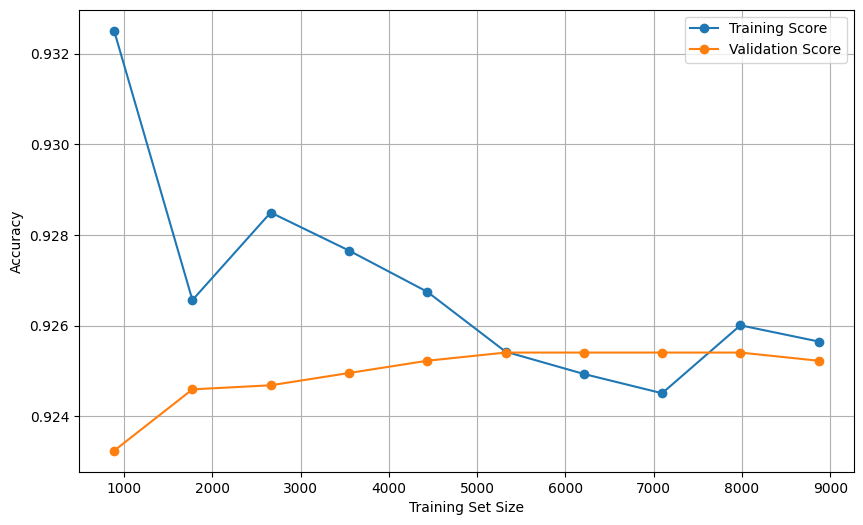

In [126]:
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, trainX, trainY, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='o')

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()